<a href="https://colab.research.google.com/github/GabrielaGroenenewegenVanDerWeijden/DS_Ass2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [5]:
!pip install tensorflow

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import cv2
import os

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [8]:
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person629_bacteria_2509.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) / 255.0  # Normalize

                data.append((resized_arr, class_num))
            except Exception as e:
                print(f"Error processing {img}: {e}")


    return np.array(data, dtype=object)

### Loading the data set

In [10]:
train = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/')
test = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/')
val = get_training_data('/kaggle/input/chest-xray-pneumonia/chest_xray/val/')

### Data visualization & Preprocessing.

<Axes: xlabel='Condition', ylabel='count'>

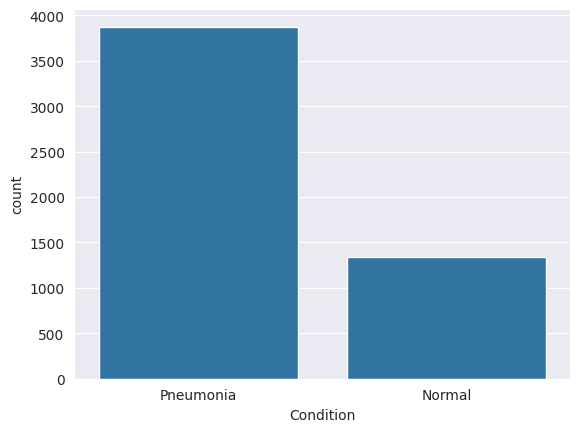

In [11]:
l = []
for i in train:
    if (i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')

#Converding the list into a dataframe so that countplot can accept it.
df = pd.DataFrame({"Condition": l})


sns.countplot(x="Condition", data=df)

### Previewing the images of both the classes.

Text(0.5, 1.0, 'NORMAL')

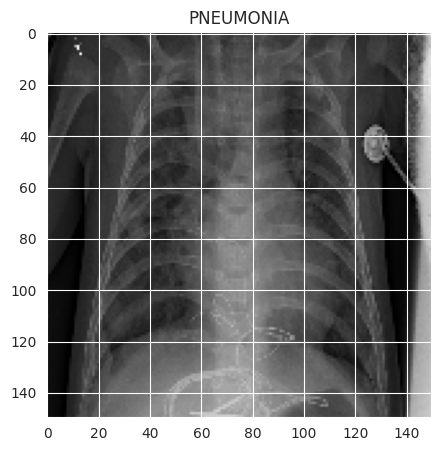

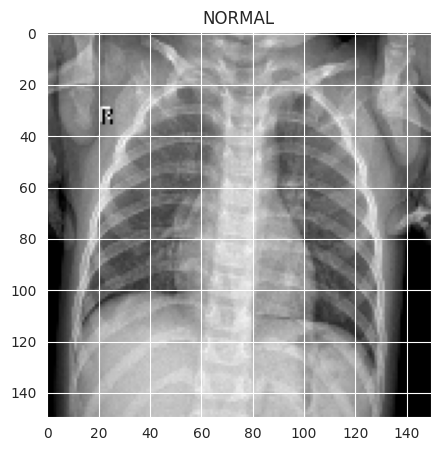

In [12]:
plt.figure(figsize= (5,5))
plt.imshow(train[0][0], cmap="gray")
plt.title(labels[train[0][1]])


plt.figure(figsize= (5,5))
plt.imshow(train[-1][0], cmap="gray")
plt.title(labels[train[-1][1]])

### We perform a grayscale normalization to reduce the effect of illumination's differences. Moreover, the CNN converges faster on [0..1] data than on [0...255]

In [13]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Make them into arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
# try to resize data to mauybe get better output.
x_train = x_train.reshape(-1, img_size, img_size, 1)


x_test = x_test.reshape(-1, img_size, img_size, 1)


x_val = x_val.reshape(-1, img_size, img_size, 1)


### Data Augmentation

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [16]:
datagen.fit(x_train)

### Training the Model

In [17]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

# DIT IS AL GERUND, DOE HET NIET OPNIEUW TENZIJ JE KOSTBARE TIJD WILT VERSPILLN

In [19]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 29s 165ms/step - loss: 0.6442 - accuracy: 0.8472 - val_loss: 6.6829 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 27s 163ms/step - loss: 0.2510 - accuracy: 0.9028 - val_loss: 21.1006 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9222
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 27s 163ms/step - loss: 0.2190 - accuracy: 0.9222 - val_loss: 17.4395 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 27s 164ms/step - loss: 0.1536 - accuracy: 0.9467 - val_loss: 19.2931 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9549
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===================

In [20]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 36ms/step - loss: 0.2555 - accuracy: 0.9215
Loss of the model is -  0.25545358657836914
20/20 [==============================] - 1s 36ms/step - loss: 0.2555 - accuracy: 0.9215
Accuracy of the model is -  92.14743375778198 %


### Analysis after model training

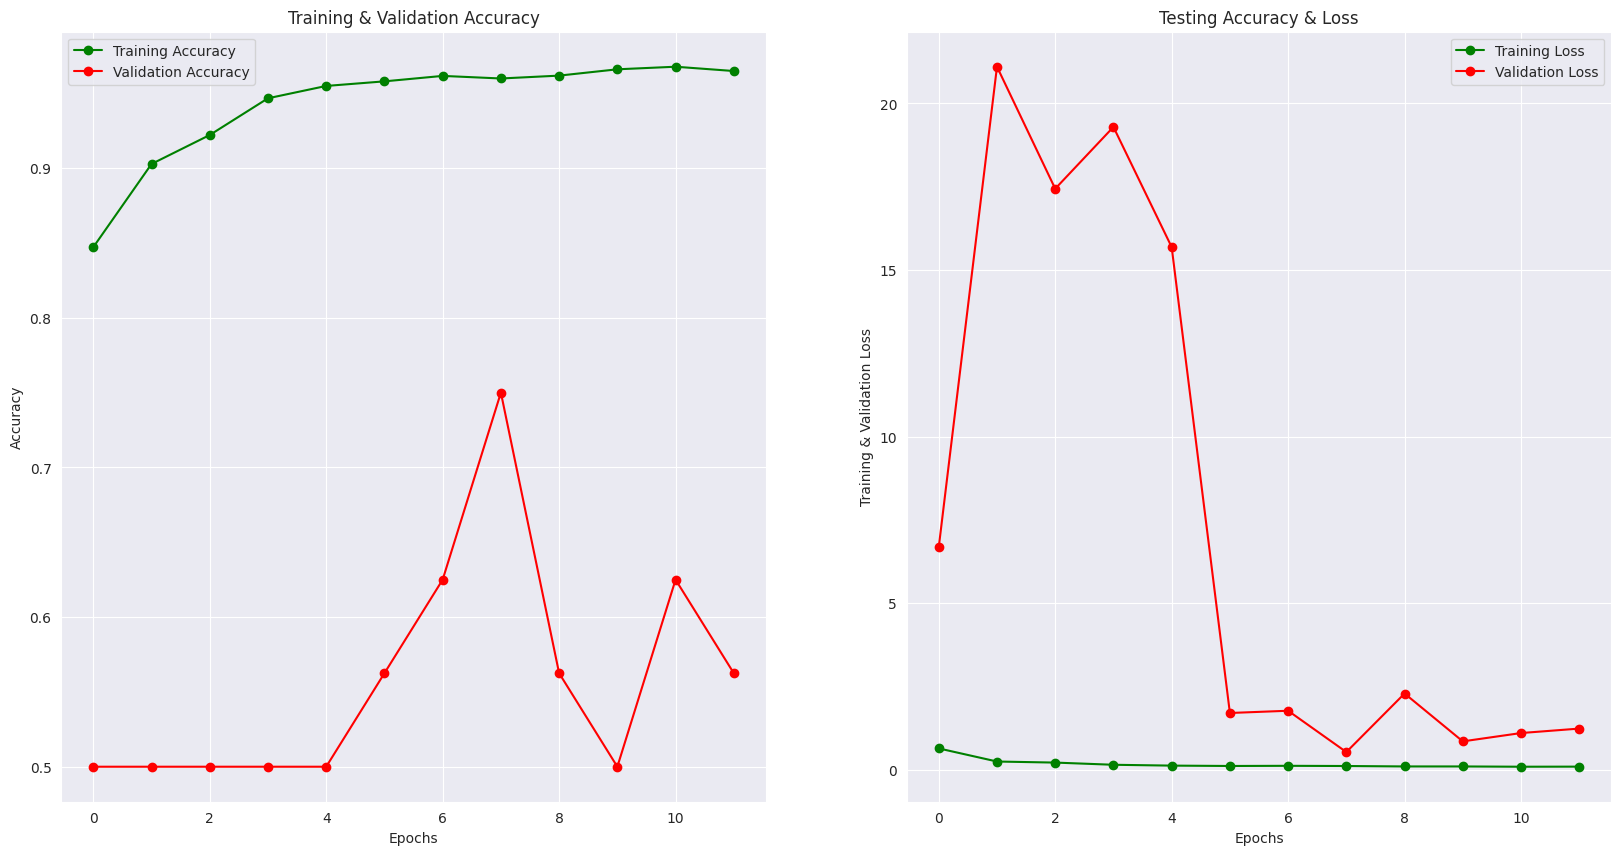

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [22]:
# predictions = model.predict_classes(x_test)
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 [==============================] - 1s 36ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0], dtype=int32)

In [23]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.92      0.86      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.92       624
       weighted avg       0.92      0.92      0.92       624



In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

In [25]:
cm = confusion_matrix(y_test,predictions)
cm

array([[373,  17],
       [ 32, 202]])

### Deze stuk hoeft aleen als er sns.heatmap gebruiken, maar dat zorgde dat niet alle cijfers zichtbaar waren dus heb CunfusionMatrixDisplay gebruikt.

In [26]:
# cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Figure size 1000x1000 with 0 Axes>

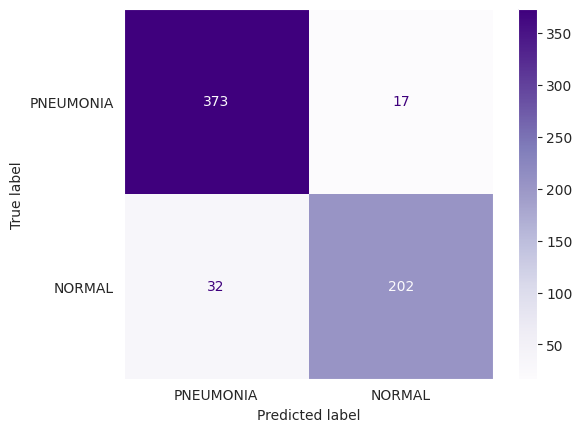

In [27]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [28]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

### Some correctly predicted classes

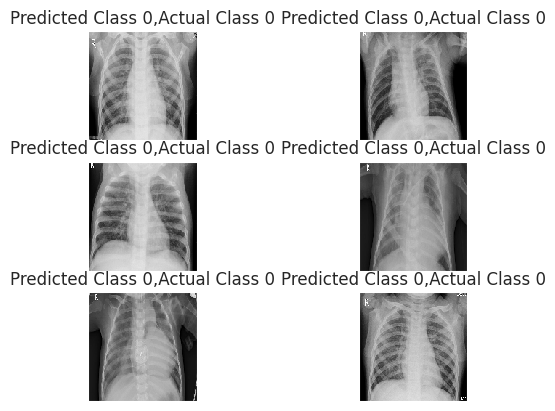

In [29]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

### Some incorrectly predicted classes

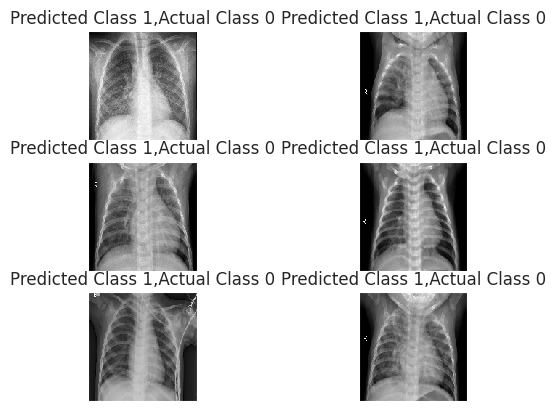

In [30]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    # plt.tight_layout()
    i += 1

##Going to Part 2 of the assignment trying to Hyper-Parameter Optimization / Bayesian Optimization


In [31]:
!pip install optuna

In [32]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.losses import BinaryCrossentropy

In [33]:
# def objective(trial):
#     # --- Hyperparameter suggestions ---
#     filters1 = trial.suggest_categorical('filters1', [32, 64])
#     dropout1 = trial.suggest_categorical('dropout1', [0.1, 0.15])
#     dropout2 = trial.suggest_categorical('dropout2', [0.15, 0.25])
#     kernel_size = trial.suggest_categorical('kernel_size', [3, 5])
#     learning_factor = trial.suggest_categorical('learning_factor', [0.1, 0.25, 0.5, 0.75, 0.9])

#     if filters1 == 32:
#         dense_units = trial.suggest_int('dense_units', 64, 128)
#     else:
#         dense_units = trial.suggest_int('dense_units', 128, 256)

#     # --- Build the model ---
#     model = Sequential()
#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1,activation='relu', padding='same', input_shape=(150, 150, 1)))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Conv2D(filters1 * 2, (kernel_size, kernel_size), strides = 1, activation='relu', padding='same'))
#     model.add(Dropout(dropout1))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides =2, padding='same'))

#     model.add(Conv2D(filters1 * 4, (kernel_size, kernel_size), strides =1, activation='relu', padding='same'))
#     model.add(Dropout(dropout2))
#     model.add(BatchNormalization())
#     model.add(MaxPool2D((2, 2), strides = 2, padding='same'))

#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dropout(dropout2))
#     model.add(Dense(1, activation='sigmoid'))

#     # --- Compile ---
#     model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])

#     # --- Callbacks ---
#     callbacks = [
#         EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
#         ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=learning_factor, min_lr=1e-6)
#     ]

#     # --- Train ---
#     history = model.fit(
#         datagen.flow(x_train, y_train, batch_size=32),
#         epochs=12,
#         validation_data=datagen.flow(x_val, y_val),
#         callbacks=callbacks
#     )

#     # Return validation accuracy of last epoch
#     return history.history['val_accuracy'][-1]


In [34]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=20)

In [35]:
model10 = Sequential()
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(32 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.1))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Conv2D(128 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(BatchNormalization())
model10.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model10.add(Flatten())
model10.add(Dense(units = 70 , activation = 'relu'))
model10.add(Dropout(0.15))
model10.add(Dense(units = 1 , activation = 'sigmoid'))
model10.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model10.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      832       
                                                                 
 batch_normalization_5 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 32)        25632     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 75, 75, 32)       

In [36]:
learning_rate_reduction10 = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [37]:
history = model10.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=40, validation_data= datagen.flow(x_val, y_val), callbacks =[learning_rate_reduction10])

Epoch 1/40
163/163 [==============================] - 29s 171ms/step - loss: 0.4115 - accuracy: 0.8338 - val_loss: 26.2392 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 26s 158ms/step - loss: 0.2534 - accuracy: 0.8992 - val_loss: 23.2464 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.9256
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 26s 160ms/step - loss: 0.2010 - accuracy: 0.9256 - val_loss: 22.9474 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 26s 159ms/step - loss: 0.1481 - accuracy: 0.9431 - val_loss: 12.3116 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/40
163/163 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9532
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==================

In [38]:
print("Loss of the model is - " , model10.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model10.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 51ms/step - loss: 0.2366 - accuracy: 0.9135
Loss of the model is -  0.23661300539970398
20/20 [==============================] - 1s 56ms/step - loss: 0.2366 - accuracy: 0.9135
Accuracy of the model is -  91.34615659713745 %


In [39]:
predictions = (model10.predict(x_test) > 0.5).astype("int32").flatten()
predictions = predictions.reshape(1,-1)[0]
predictions[:46]

20/20 [==============================] - 1s 56ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

In [40]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.97      0.93       390
   Normal (Class 1)       0.94      0.82      0.88       234

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.91       624
       weighted avg       0.92      0.91      0.91       624



In [41]:
cm = confusion_matrix(y_test,predictions)

<Figure size 1000x1000 with 0 Axes>

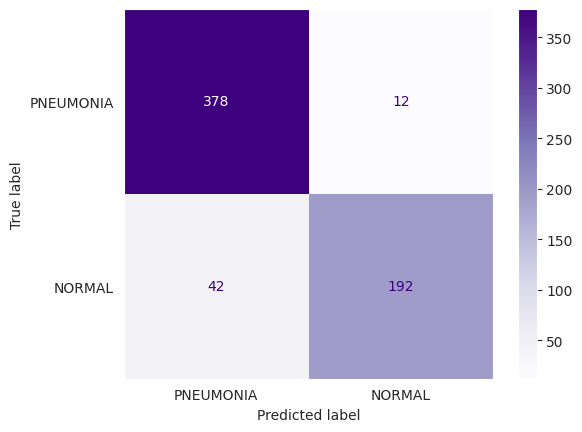

In [42]:
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Purples', colorbar=True)
plt.grid(False)


In [53]:
model10.save("91_Percent.keras")

##Part 3: XAI


In [43]:
!pip uninstall -y tensorflow tensorflow-text tf-keras jax ml-dtypes protobuf grpcio-status google-cloud-pubsub


Found existing installation: tensorflow 2.15.1
Uninstalling tensorflow-2.15.1:
  Successfully uninstalled tensorflow-2.15.1
Found existing installation: tensorflow-text 2.18.1
Uninstalling tensorflow-text-2.18.1:
  Successfully uninstalled tensorflow-text-2.18.1
Found existing installation: tf_keras 2.18.0
Uninstalling tf_keras-2.18.0:
  Successfully uninstalled tf_keras-2.18.0
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: ml-dtypes 0.3.2
Uninstalling ml-dtypes-0.3.2:
  Successfully uninstalled ml-dtypes-0.3.2
Found existing installation: protobuf 4.25.6
Uninstalling protobuf-4.25.6:
  Successfully uninstalled protobuf-4.25.6
Found existing installation: grpcio-status 1.71.0
Uninstalling grpcio-status-1.71.0:
  Successfully uninstalled grpcio-status-1.71.0
Found existing installation: google-cloud-pubsub 2.29.0
Uninstalling google-cloud-pubsub-2.29.0:
  Successfully uninstalled google-cloud-pubsub-2.29.0

In [44]:
!pip install tensorflow==2.18.0
!pip install tensorflow-text==2.18.1
!pip install tf-keras==2.18.0
!pip install jax==0.5.2
!pip install ml-dtypes==0.4.0
!pip install protobuf==5.26.1
!pip install grpcio-status==1.71.0
!pip install google-cloud-pubsub==2.29.0


  Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached tensorflow-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.4 MB)
Using cached keras-3.9.2-py3-none-any.whl (1.3 MB)
Using cached ml_dtypes-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached protobuf-5.29.4-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempti

  Using cached tensorflow_text-2.18.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_text-2.18.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.2 MB)
  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tf_keras-2.18.0-py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
  Using cached jax-0.5.2-py3-none-any.whl.metadata (22 kB)
Using cached jax-0.5.2-py3-none-any.whl (2.4 MB)


  Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.4.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xplique 1.4.0 requires tensorflow<2.16.0,>=2.1.0, but you have tensorflow 2.18.0 which is incompatible.


  Using cached protobuf-5.26.1-cp37-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.26.1-cp37-abi3-manylinux2014_x86_64.whl (302 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires google-cloud-pubsub>=2.21.4, which is not installed.
xplique 1.4.0 requires tensorflow<2.16.0,>=2.1.0, but you have tensorflow 2.18.0 which is incompatible.
  Using cached grpcio_status-1.71.0-py3-none-any.whl.metadata (1.1 kB)
Using cached grpcio_status-1.71.0-py3-none-any.whl (14 kB)


  Using cached google_cloud_pubsub-2.29.0-py2.py3-none-any.whl.metadata (9.7 kB)
Using cached google_cloud_pubsub-2.29.0-py2.py3-none-any.whl (317 kB)


In [45]:
!pip install xplique==0.3.0


  Using cached Xplique-0.3.0-py3-none-any.whl.metadata (20 kB)
Using cached Xplique-0.3.0-py3-none-any.whl (112 kB)
  Attempting uninstall: xplique
    Found existing installation: Xplique 1.4.0
    Uninstalling Xplique-1.4.0:
      Successfully uninstalled Xplique-1.4.0


In [46]:
!pip install xplique --upgrade

  Using cached Xplique-1.4.0-py3-none-any.whl.metadata (35 kB)
  Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached Xplique-1.4.0-py3-none-any.whl (267 kB)
Using cached tensorflow-2.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.3 MB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: protobuf
    Found existing installation: p

In [47]:
import xplique
from xplique.plots import plot_attributions


In [48]:
!pip install overcomplete


In [49]:
import overcomplete

In [50]:
from xplique.attributions import GradCAM
import tensorflow.keras.applications as app

In [89]:
# Out pictures
# train, test, val, y_train, x_train, x_val, y_val, x_test, y_test


# X data is already preprocessed above
X = np.concatenate((x_train, x_val, x_test), axis = 0)
Y = np.concatenate((y_train, y_val, y_test), axis = 0)

# load the model and preprocess the inputs (adapt the input range)
preprocessing = app.mobilenet_v2.preprocess_input
X_preprocessed = preprocessing(np.array(X, copy=True))

# create an explainer and generate explanations
explainer = GradCAM(model10)
explanations = explainer(X_preprocessed, Y) # `explainer.explain(inputs, labels)` also works




Cause: could not parse the source code of <function GradCAM.explain.<locals>.<lambda> at 0x7885371cb9c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function GradCAM.explain.<locals>.<lambda> at 0x7885371cb9c0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


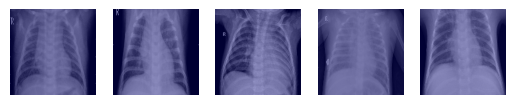

In [115]:
#Plot that shit
for i in range(5):
  j = i + 450
  plt.subplot(1, 5, i +1)
  plt.imshow(X[j], cmap = "gray")
  plt.imshow(explanations[j], cmap="jet", alpha = 0.4)
  plt.axis("off")

In [117]:
from IPython.display import Image, display

### Making the GradCAM algorithm from scratch


In [142]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()


conv2d_9
183/183 [==============================] - 7s 40ms/step
Predicted: ['Pneumonia', 'Normal', 'Normal', 'Pneumonia', 'Pneumonia']


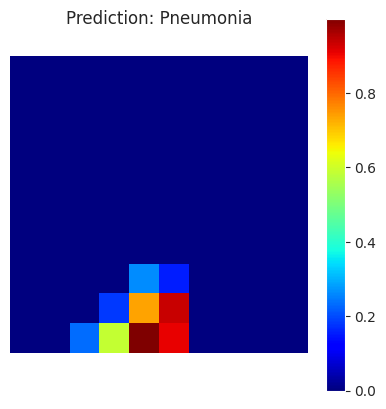

In [144]:
# Get last convolutional layer
last_conv_layer = [layer for layer in model10.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

print(last_conv_layer.name)
# Instead of using xception.decode_predictions, which is designed for ImageNet (1000 classes)
# We'll interpret the raw predictions from our binary classifier
def decode_binary_predictions(preds):
    """Decodes predictions for a binary classification model."""
    predicted_classes = (preds > 0.5).astype(int)  # Threshold at 0.5
    class_labels = ['Pneumonia', 'Normal']  # Assuming labels are in this order
    return [class_labels[pred] for pred in predicted_classes.flatten()]

# Prepare images
X = np.concatenate((x_train, x_val, x_test), axis = 0)
Y = np.concatenate((y_train, y_val, y_test), axis = 0)

X = X.reshape(-1, 150, 150, 1)


# Our model
ours = model10

# Remove last layer's softmax (if it was applied)
# This might be unnecessary depending on your model definition
ours.layers[-1].activation = None

# Print what the top predicted class is using the custom decoding function
preds = ours.predict(X)
predicted_labels = decode_binary_predictions(preds)
print("Predicted:", predicted_labels[:5])  # Print first 5 predictions for illustration


heatmaps = []
for i in range(len(X)):
    img = np.expand_dims(X[i], axis=0)  # (1, 150, 150, 1)
    heatmap = make_gradcam_heatmap(img, ours, last_conv_layer.name)
    heatmaps.append(heatmap)

heatmap = np.array(heatmaps)  # Combine heatmaps from all batches


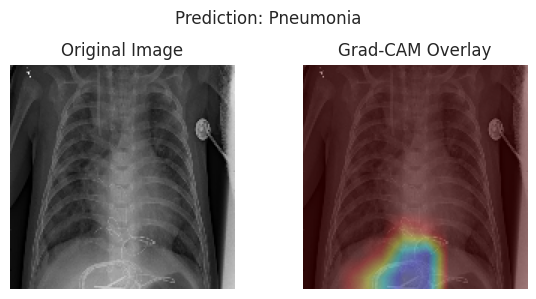

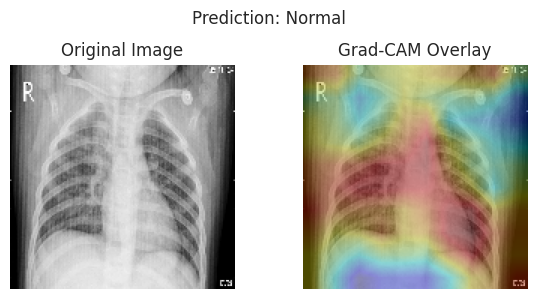

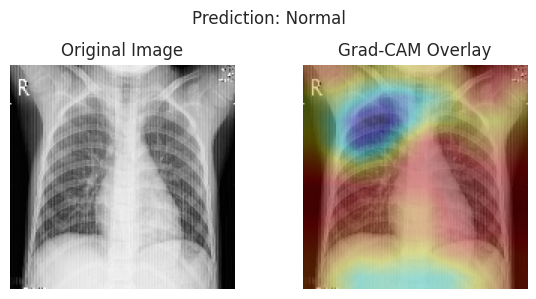

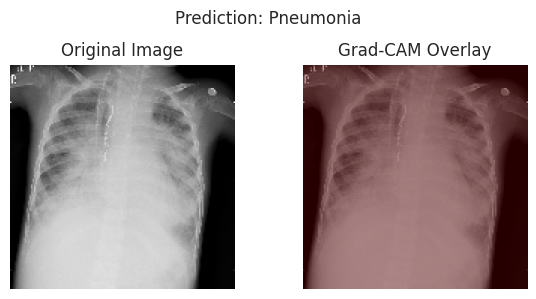

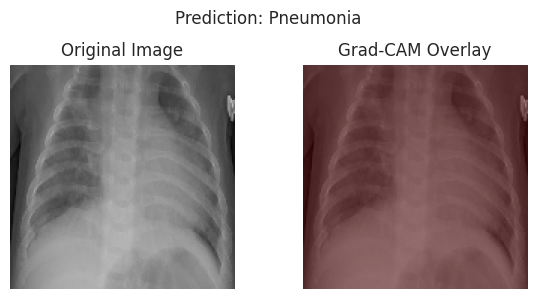

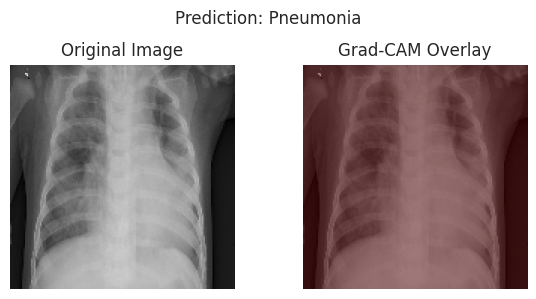

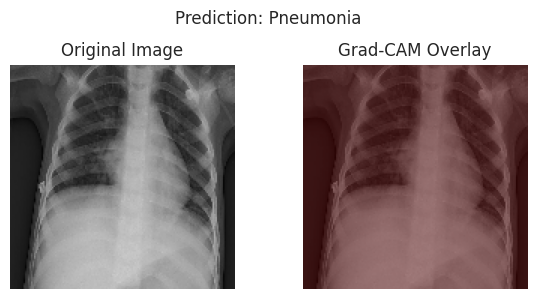

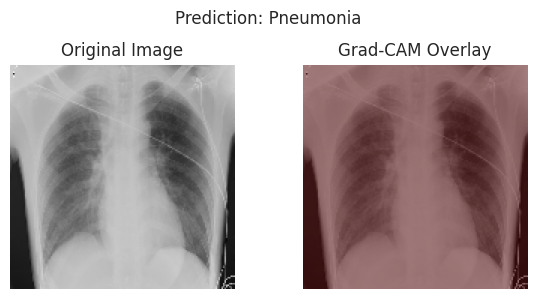

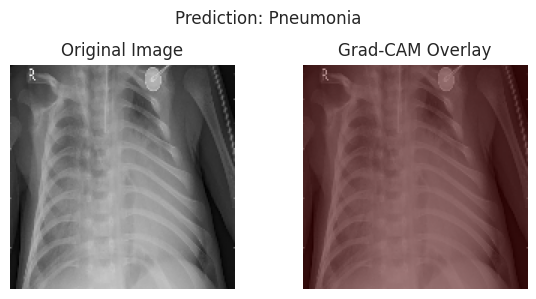

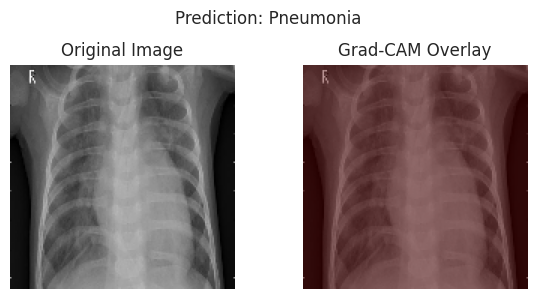

In [161]:

for i in range(10):  # Adjust how many samples you want to visualize
    heatmap = heatmaps[i]
    input_img = X[i].squeeze()  # Shape: (150, 150), normalized (0–1)

    # Resize heatmap to input size
    heatmap_resized = cv2.resize(heatmap, (150, 150))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Convert grayscale image to RGB
    input_rgb = cv2.cvtColor(np.uint8(input_img * 255), cv2.COLOR_GRAY2RGB)

    # Overlay heatmap
    overlay = cv2.addWeighted(input_rgb, 0.6, heatmap_color, 0.3, 0)

    # Plot original + overlay
    plt.figure(figsize=(6, 3))
    plt.suptitle(f"Prediction: {predicted_labels[i]}")

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(input_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()